# Import Modules

In [1]:
import dataset as ds
import config as cfg
from evaluate import Evaluate
import tools

from sklearn.model_selection import train_test_split
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Rescaling, Dropout
from tensorflow.keras.metrics import Precision, Recall

from clearml import Task
import clearml
clearml.browser_login()


# ClearML
https://app.clear.ml/dashboard

# Import Dataset

In [2]:
# Base paths for the images and labels
train_images_path = f'{cfg.BASE_DATASET}/images/train'
train_labels_path = f'{cfg.BASE_DATASET}/labels/train'
val_images_path = f'{cfg.BASE_DATASET}/images/valid'
val_labels_path = f'{cfg.BASE_DATASET}/labels/valid'

# Base path for metadata
metadata_path = f'{cfg.BASE_DATASET}/metadata.json'

# Create the DataFrames for the train and validation sets
train_df = ds.create_dataframe(train_images_path, train_labels_path, metadata_path)
valid_df = ds.create_dataframe(val_images_path, val_labels_path, metadata_path)

# Test Parameters

In [3]:
project_name= cfg.CLF_PROJECT_NAME + '/epoch_test'
dataset_name = 'test500'
dataset_dir = cfg.CLF_DATASET_DIR + f'/{dataset_name}'
project_dir = f'{cfg.CLF_PROJECT_DIR}/{dataset_name}/'
class_names = cfg.CLF_CLASS_NAMES

zoom_factor = 1.5

epochs = 50
N = 20






RUN = 5








task_name = 'epoch_test'
task_name = f'{task_name}-{epochs}-{RUN}'

augmentation_metadata = {
    'methods': {        
        'flip': {
            'parameters': {
                'orientation': 'h',  # Could be 'h' for horizontal or 'v' for vertical
                'p': 1.0  # Probability of applying the augmentation
            },
            'apply_to_percentage': 0.5  # 50% of the training images
        }        
    }
}

train_size = 500
val_size = 100


In [4]:
_, test_train_df = train_test_split(
    train_df,
    test_size=train_size,  # Number of items you want in your sample
    stratify=train_df['ac'],  # Stratify based on the combined column
    #random_state=42  # Ensures reproducibility
)

_, test_val_df = train_test_split(
    valid_df,
    test_size=val_size,  # Number of items you want in your sample
    stratify=valid_df['ac'],  # Stratify based on the combined column
    #random_state=42  # Ensures reproducibility
)

# create dataset directory from dataframes above
ds.create_sub_dataset(dataset_dir, test_train_df, test_val_df, class_names)

# Pre-processing to AID classification (apply zoom factor to all images)
ds.pre_process_dataset_for_classification(dataset_dir, zoom_factor)

# correct single class labels to accomodate for multi-class classification
ds.correct_dataset_labels(dataset_dir, test_train_df, test_val_df, class_names)

# augment dataset
ds.augment_dataset(dataset_dir, augmentation_metadata)

# create class folders within train and valid directories for keras format
ds.reorganize_dataset_for_keras(dataset_dir)

Removing dataset if pre-existing
Copying training files:


Copying files:   0%|          | 0/1000 [00:00<?, ?it/s]

Copying validation files:


Copying files:   0%|          | 0/200 [00:00<?, ?it/s]

Dataset 'test500' created at C:\github\Third-Year-Project\Intruder-Aircraft-Detection\datasets\Custom\test500


Processing images:   0%|          | 0/500 [00:00<?, ?it/s]

An error occurred with C:/github/Third-Year-Project/Intruder-Aircraft-Detection/datasets/Custom/test500\images\train\45034.jpg: Expected x_max for bbox (0.33537100000000003, 0.039870499999999975, 1.207841, 0.6215175, 0) to be in the range [0.0, 1.0], got 1.207841.
An error occurred with C:/github/Third-Year-Project/Intruder-Aircraft-Detection/datasets/Custom/test500\images\train\50732.jpg: Expected x_min for bbox (-0.02266499999999999, 0.5461069999999999, 0.560295, 0.9347469999999999, 0) to be in the range [0.0, 1.0], got -0.02266499999999999.
An error occurred with C:/github/Third-Year-Project/Intruder-Aircraft-Detection/datasets/Custom/test500\images\train\69424.jpg: Expected y_max for bbox (0.003923500000000024, 0.6038205, 0.8627024999999999, 1.1763395, 0) to be in the range [0.0, 1.0], got 1.1763395.


Processing images:   0%|          | 0/100 [00:00<?, ?it/s]

Processing train labels in test500:


Processing labels:   0%|          | 0/500 [00:00<?, ?it/s]

File not found: C:/github/Third-Year-Project/Intruder-Aircraft-Detection/datasets/Custom/test500/labels/train\69424.txt
File not found: C:/github/Third-Year-Project/Intruder-Aircraft-Detection/datasets/Custom/test500/labels/train\50732.txt
File not found: C:/github/Third-Year-Project/Intruder-Aircraft-Detection/datasets/Custom/test500/labels/train\45034.txt
Processing valid labels in test500:


Processing labels:   0%|          | 0/100 [00:00<?, ?it/s]

Label correction completed.


Removing existing directories/files:   0%|          | 0/3 [00:00<?, ?it/s]

Copying files:   0%|          | 0/497 [00:00<?, ?it/s]

Copying files:   0%|          | 0/497 [00:00<?, ?it/s]

Applying augmentations:   0%|          | 0/248 [00:00<?, ?it/s]

Moving images in train:   0%|          | 0/497 [00:00<?, ?it/s]

Moving images in train-aug:   0%|          | 0/745 [00:00<?, ?it/s]

Moving images in valid:   0%|          | 0/100 [00:00<?, ?it/s]

# Image Classifier

In [5]:
tf.keras.utils.set_random_seed(42)

In [6]:

train_dir = os.path.join(dataset_dir,'images','train')
train_aug_dir = os.path.join(dataset_dir,'images','train-aug')
valid_dir = os.path.join(dataset_dir,'images','valid')

batch_size = 32 
img_height = 256
img_width = 256

# load datasets using keras
train_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    seed=42,
    image_size=(img_height, img_width),
    shuffle=True)

train_aug_data = tf.keras.utils.image_dataset_from_directory(
    train_aug_dir,
    batch_size=batch_size,
    seed=42,
    image_size=(img_height, img_width),
    shuffle=True)

valid_data = tf.keras.utils.image_dataset_from_directory(
    valid_dir,
    batch_size=batch_size,
    seed=42,
    image_size=(img_height, img_width),    
    shuffle=True)


print(class_names)

Found 497 files belonging to 3 classes.
Found 745 files belonging to 3 classes.
Found 100 files belonging to 3 classes.
['Cessna Skyhawk', 'Boeing 737-800', 'King Air C90']


In [7]:
# hyper-parameters
hyper_params = {
    'dataset': dataset_name,
    'original_dataset_size': {'train_size': train_size, 'val_size': val_size},
    'train_size': tools.count_images(train_dir),
    'train_aug_size': tools.count_images(train_aug_dir),
    'valid_size': tools.count_images(valid_dir),
    'epochs': epochs, 
    'N': N,
    'zoom_factor': zoom_factor, 
    'batch_size': batch_size, 
    'img_height': img_height, 
    'img_width': img_width, 
    'class_names': class_names
    }

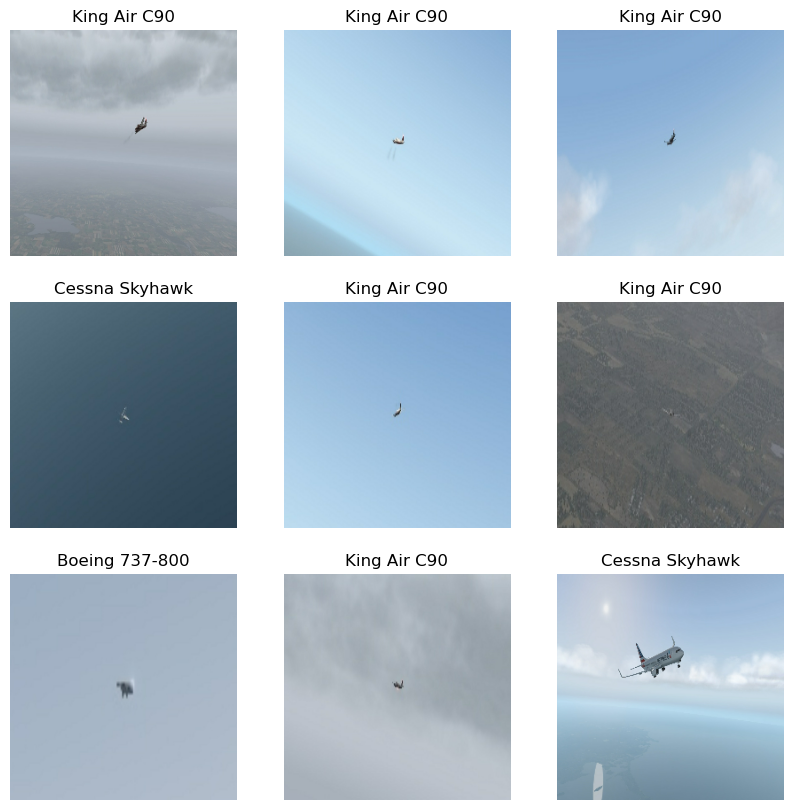

In [8]:
# test visualise 
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_aug_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
# convert labels to one-hot encoding to allow for more metrics to be tracked
def one_hot_enc(image, label):
    return image, tf.one_hot(label, len(class_names))

train_data = train_data.map(one_hot_enc)
train_aug_data = train_aug_data.map(one_hot_enc)
valid_data = valid_data.map(one_hot_enc)

# check one hot new shape
for image_batch, labels_batch in train_data:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32, 3)


In [10]:
# Set up data pipelines for train and val: 
# cache datasets to reduce I/O operations 
# shuffle training data for robustness
# AUTOTUNE to dynamically optimize prefetching

AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.cache().shuffle(1000, seed=42).prefetch(buffer_size=AUTOTUNE)
train_aug_data = train_aug_data.cache().shuffle(1000, seed=42).prefetch(buffer_size=AUTOTUNE)
valid_data = valid_data.cache().prefetch(buffer_size=AUTOTUNE)




In [11]:
# get list of validation labels (y_true) for evaluation
validation_labels = []
for images, labels in valid_data:
    validation_labels.append(labels.numpy())

validation_labels = np.concatenate(validation_labels)

In [12]:
# CNN for image classification
def get_model(): 
  # number of classes
  num_classes = len(class_names) 
  model = Sequential([
    Input(shape=(img_height, img_width, 3)), # inputs shape, height, width, channels (RGB)
    Rescaling(1./255), # normalize pixel values
    Conv2D(16, 3, padding='same', activation='relu'), # 16 filters, 3x3 kernel, relu activation
    MaxPooling2D(), # performs 2D max pooling
    Conv2D(32, 3, padding='same', activation='relu'), # 32 filters, 3x3 kernel, relu activation
    MaxPooling2D(), # 2D max pooling
    Conv2D(64, 3, padding='same', activation='relu'), # 64 filters, 3x3 kernel, relu activation
    MaxPooling2D(), # 2D max pooling
    Dropout(0.2), # dropout layer to increase regularization and reduce overfitting
    Flatten(), # flattens output of previos layer to 1D
    Dense(128, activation='relu'),      
    Dense(num_classes, activation='softmax') 
  ])
  
  # compile model  
  model.compile(optimizer='adam', # use Adam optimizer
                loss='categorical_crossentropy', # use categorical crossentropy loss for mutliclass classification
                metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]) # trach accuracy, precision, recall (and loss)

  # print model summary
  #model.summary()
  
  return model

In [13]:
# Train Pure

# local logs directory
logs_dir=cfg.CLF_PROJECT_DIR
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logs_dir)

#connect to clearml
task = Task.init(project_name=project_name, task_name=f"{task_name}-pure")
logger = task.get_logger()

# clearml hyperparameters
task.connect(hyper_params)

# ensure model from scratch and get model

model = get_model()

# train model
print('Training model...')
train_hst = model.fit(
    train_data, 
    epochs=hyper_params['epochs'], 
    validation_data=valid_data,
    callbacks=[tensorboard_callback]
    )

# predict on validation set
print('Predicting on validation set...')
y_pred = model.predict(valid_data)

# evaluate
pure_eval = Evaluate(train_hst, validation_labels, y_pred, class_names, aug=False, sf=3)

# send metrics to clearML
pure_eval.log_metrics(task, logger, N, None, hyper_params)


# close task
print("done")


ClearML Task: created new task id=52020bf8f1c2491d85ba1b508c0f9d46
2024-04-30 21:27:47,617 - clearml.Task - INFO - Storing jupyter notebook directly as code


ClearML results page: https://app.clear.ml/projects/ce0a85b8772540cbbcbfcfb4dd2149e9/experiments/52020bf8f1c2491d85ba1b508c0f9d46/output/log
Training model...
Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 218ms/step - accuracy: 0.3176 - loss: 2.3389 - precision: 0.3611 - recall: 0.2185 - val_accuracy: 0.3400 - val_loss: 1.0985 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 201ms/step - accuracy: 0.3536 - loss: 1.0985 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3500 - val_loss: 1.0986 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 197ms/step - accuracy: 0.3505 - loss: 1.0999 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3300 - val_loss: 1.1022 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
1

In [14]:
# Train Augmented

# local logs directory, callbacks allow for real time metrics in clearML
logs_dir=cfg.CLF_PROJECT_DIR
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logs_dir)

#connect to clearml
task = Task.init(project_name=project_name, task_name=f"{task_name}-aug")
logger = task.get_logger()


# clearml hyperparameters
task.connect(hyper_params)

# ensure model from scratch and get model
model_aug = get_model()

# train model
print('Training model...')
train_aug_hst = model_aug.fit(
    train_aug_data, 
    epochs=hyper_params['epochs'], 
    validation_data=valid_data, 
    callbacks=[tensorboard_callback]
    )

# predict on validation set
print('Predicting on validation set...')
y_pred_aug = model_aug.predict(valid_data)

# evaluate
aug_eval = Evaluate(train_aug_hst, validation_labels, y_pred_aug, class_names, aug=True, sf=3)

# send metrics to clearML
aug_eval.log_metrics(task, logger, N, augmentation_metadata, hyper_params) 
 
# close task
print("done")


ClearML Task: created new task id=e1da4892b8a04e278e24ad70eb9064c7
ClearML results page: https://app.clear.ml/projects/ce0a85b8772540cbbcbfcfb4dd2149e9/experiments/e1da4892b8a04e278e24ad70eb9064c7/output/log
Training model...
Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 223ms/step - accuracy: 0.3415 - loss: 2.6095 - precision: 0.3044 - recall: 0.1825 - val_accuracy: 0.3300 - val_loss: 1.0986 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 193ms/step - accuracy: 0.3269 - loss: 1.0987 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3300 - val_loss: 1.1035 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step - accuracy: 0.3625 - loss: 1.0987 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3300 - val_loss: 1.1028 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 190ms/step - accuracy: 0.3681 - loss: 1.0969 - precision: 0.500

In [15]:
#task.close()

# Evaluation

All metrics have been fully logged in ClearML, this section is just for quick performance metrics not complete evaluation

In [16]:
# pure accuracy

#pure_eval.average_accuracy(True)
#print()
#pure_eval.std_accuracy(True)
#print()
pure_eval.best_accuracy(True)
print()
#pure_eval.last_accuracy(True)
#print()



Best Accuracy - pure: 0.913
Best Val Accuracy - pure: 0.73



In [17]:
# augmented accuracy

#aug_eval.average_accuracy(True)
#print()
#aug_eval.std_accuracy(True)
#print()
aug_eval.best_accuracy(True)
print()
#aug_eval.last_accuracy(True)
#print()


Best Accuracy - augmented: 0.972
Best Val Accuracy - augmented: 0.77



In [18]:
# Area under the ROC curve 
pure_eval.overall_auc(True)
aug_eval.overall_auc(True)
print()

Overall AUC - pure: 0.811
Overall AUC - augmented: 0.81



In [19]:
# Max validation F1 score 
pure_eval.max_f1(True)
aug_eval.max_f1(True)
print()

Max F1 score - pure:  0.717  at epoch:  47
Max F1 score - augmented:  0.774  at epoch:  43



In [20]:
# loss

# minimum vakidation loss
#pure_eval.min_loss(True)
#aug_eval.min_loss(True)
#print()

# difference in average loss between training and validation sets for the last N epochs
pure_eval.diff_avg_loss_lastN(N,True)
aug_eval.diff_avg_loss_lastN(N,True)
print()

# standard deviation of loss for the last N epochs
#pure_eval.std_loss_lastN(N,True)
#aug_eval.std_loss_lastN(N,True)
#print()




Diff Avg Loss - pure: 1.233
Diff Avg Loss - augmented: 1.812



# Class Specific Evaluation

In [21]:
# pure class auc

#pure_eval.confusion_matrix_class_report(False)
#print()

pure_eval.class_auc(True)
print()


AUC per class - pure:

  Cessna Skyhawk: 0.754
  Boeing 737-800: 0.927
  King Air C90: 0.752



In [22]:
# augmented class auc
#aug_eval.confusion_matrix_class_report(True)
#print()

aug_eval.class_auc(True)    
print()



AUC per class - augmented:

  Cessna Skyhawk: 0.769
  Boeing 737-800: 0.944
  King Air C90: 0.716

